In [129]:
import numpy as np
import gymnasium as gym 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import imageio
import pandas as pd

## Activity 2: **MC for Taxi**

In [130]:
def train_mc_agent(config, n_episodes=10000, max_steps=100):

    env = gym.make('Taxi-v3')
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    
    gamma = config["gamma"]
    alpha = config["alpha"]
    decay_rate = config["decay_rate"]
    epsilon_min = config.get("epsilon_min", 0.01)
    epsilon_max = config.get("epsilon_max", 1.0)

    total_rewards = []

    def epsilon_greedy_policy(state, epsilon):
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(Q[state])

    for episode in range(n_episodes):
        state, _ = env.reset()
        if config['decay_type'] == 'exponential':
            epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-decay_rate * episode)
        elif config['decay_type'] == 'linear':
            epsilon = max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * (episode / n_episodes))


        episode_states = []
        episode_actions = []
        episode_rewards = []

        for step in range(max_steps):
            action = epsilon_greedy_policy(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)

            if done:
                break

            state = next_state

        G = 0
        for t in range(len(episode_states) - 1, -1, -1):
            state = episode_states[t]
            action = episode_actions[t]
            G = gamma * G + episode_rewards[t]

            N[state, action] += 1
            Q[state, action] += alpha * (G - Q[state, action])

        total_rewards.append(sum(episode_rewards))
    
    avg_reward = np.mean(total_rewards[-1000:])

    print('Training Complete')

    return {
        "Q": Q,
        "rewards": total_rewards,
        "avg_reward": avg_reward,
        "config": config,
        "ε": epsilon,
        "env": env
    }

def evaluate_policy(Q, env, n_episodes=100, render=False, max_steps=100):
    total_rewards = []
    total_steps = []
    successful_episodes = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done and steps < max_steps:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1

            if render:
                env.render()

        if reward == 20:
            successful_episodes += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    success_rate = successful_episodes / n_episodes

    print(f"Evaluation Results over {n_episodes} episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Steps to Finish: {avg_steps:.2f}")
    print(f"Success Rate: {success_rate * 100:.2f}%")

def action_to_symbol(action):
    return ['↓', '↑', '→', '←', 'p', 'd'][action]

def visualize_policy_grid(Q, env, passenger=0, destination=2):
    passenger_map = {
        0: "Red (R)",
        1: "Green (G)",
        2: "Yellow (Y)",
        3: "Blue (B)",
        4: "In Taxi"
    }
    destination_map = {
        0: "Red (R)",
        1: "Green (G)",
        2: "Yellow (Y)",
        3: "Blue (B)"
    }

    print(f"Taxi policy when passenger is at location {passenger_map[passenger]} and destination is {destination_map[destination]}")
    for row in range(5):
        line = ''
        for col in range(5):
            state = env.unwrapped.encode(row, col, passenger, destination)
            best_action = np.argmax(Q[state])
            symbol = action_to_symbol(best_action)
            line += symbol + ' '
        print(line)

### Training Loop (Linear decay)

In [131]:
config = {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.0005, 'decay_type': 'linear'}

result = train_mc_agent(config, 10000, 100)
print(f"Config: {config}")
print(f'Avg Reward: {result['avg_reward']} | ε: {result['ε']}')

Training Complete
Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.0005, 'decay_type': 'linear'}
Avg Reward: -5.553 | ε: 0.010098999999999969


### Evaluation

In [132]:
evaluate_policy(result['Q'], result['env'], 100)

Evaluation Results over 100 episodes:
Avg Total Reward: 0.31
Avg Steps to Finish: 19.43
Success Rate: 94.00%


In [133]:
# Visual
env = gym.make('Taxi-v3', render_mode = 'human')

Q = result['Q']
max_steps = 100
n_test_episodes = 10
test_rewards = []
env.reset()
env.render()

for _ in range(n_test_episodes):
    state = env.reset()[0]
    episode_reward = 0
    
    for _ in range(max_steps):
        action = np.argmax(Q[state])
        next_state, reward, done, _, _ = env.step(action)
        env.render()
        episode_reward += reward
        if done:
            break
        state = next_state
    
    test_rewards.append(episode_reward)

print(f"Average reward over {n_test_episodes} test episodes: {np.mean(test_rewards):.2f}")

Average reward over 10 test episodes: -5.10


### Visualize Q Table

In [134]:
print(result['Q'])

[[  0.           0.           0.           0.           0.
    0.        ]
 [-20.66912303 -27.0026581  -15.781649    -7.3633863    8.97969957
  -19.40839093]
 [-33.97904806 -12.91387517 -21.00400095 -14.68595889  11.54497572
  -36.46258915]
 ...
 [-22.80813861  -1.20119909 -29.76372529 -31.31355953 -22.42119464
  -29.61021025]
 [-44.02043234  10.23273694 -20.72453219 -68.10759226 -28.2283362
  -34.24445006]
 [  8.23303966   6.31254068   7.36115683  18.33776807   2.33472283
    1.28406814]]


### Policy Visualization (Dropoff & Pickup)

In [135]:
print("Visualizing grid before taxi pickup:")
visualize_policy_grid(result['Q'], result['env'], 0, 2)

print()

print("Visualizing grid after taxi pickup:")
visualize_policy_grid(result['Q'], result['env'], 4, 2)

Visualizing grid before taxi pickup:
Taxi policy when passenger is at location Red (R) and destination is Yellow (Y)
p ← ↓ ↓ ← 
↑ ← ↓ ↓ ← 
↑ ↑ ↓ ← ↓ 
↑ ↑ ← ↑ ← 
↑ ↑ ↑ → ↑ 

Visualizing grid after taxi pickup:
Taxi policy when passenger is at location In Taxi and destination is Yellow (Y)
→ ↓ → ↓ ← 
→ ↓ → ↓ → 
↓ ← ← ← ← 
↓ ↑ ↑ ↓ ↑ 
d ↑ ↓ → ↑ 


### Test & Compare Hyperparameters

In [136]:
test_configs = [
    {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.0005},
    {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.001},
    {"gamma": 0.99, "alpha": 0.3, "decay_rate": 0.0005},
    {"gamma": 0.99, "alpha": 0.5, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.3, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.5, "decay_rate": 0.0005},
]

results_list = []

for cfg in test_configs:
    for decay_type in ['linear', 'exponential']:
        cfg_copy = cfg.copy()
        cfg_copy['decay_type'] = decay_type
        result = train_mc_agent(cfg_copy)
        print(f"Config: {cfg_copy}")
        print(f'Avg Reward: {result['avg_reward']} | ε: {result['ε']}')
        results_list.append(result)

Training Complete
Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.0005, 'decay_type': 'linear'}
Avg Reward: -67.565 | ε: 0.010098999999999969
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.0005, 'decay_type': 'exponential'}
Avg Reward: 4.873 | ε: 0.016673903646819088
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.001, 'decay_type': 'linear'}
Avg Reward: -48.677 | ε: 0.010098999999999969
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.001, 'decay_type': 'exponential'}
Avg Reward: -82.257 | ε: 0.010044990898875783
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.3, 'decay_rate': 0.0005, 'decay_type': 'linear'}
Avg Reward: -175.12 | ε: 0.010098999999999969
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.3, 'decay_rate': 0.0005, 'decay_type': 'exponential'}
Avg Reward: -127.043 | ε: 0.016673903646819088
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.5, 'decay_rate': 0.001, 'decay_type': 'linear'}

In [137]:
best_result = max(results_list, key = lambda x: x['avg_reward']) # Based on best reward and not time

print('Best Config:')
if best_result['config']['decay_type'] == 'exponential':
    print(f"Gamma: {best_result['config']['gamma']}")
    print(f"Alpha: {best_result['config']['alpha']}")
    print(f"Decay Rate: {best_result['config']['decay_rate']}")
    print(f"Decay Type: {best_result['config']['decay_type']}")
    print(f"Final ε: {best_result['ε']:.4f}")
    print(f"Avg Reward: {best_result['avg_reward']:.2f}")
else:
    print(f"Gamma: {best_result['config']['gamma']}")
    print(f"Alpha: {best_result['config']['alpha']}")
    print(f"Decay Type: {best_result['config']['decay_type']}")
    print(f"Final ε: {best_result['ε']:.4f}")
    print(f"Avg Reward: {best_result['avg_reward']:.2f}")

Best Config:
Gamma: 0.99
Alpha: 0.1
Decay Rate: 0.0005
Decay Type: exponential
Final ε: 0.0167
Avg Reward: 4.87


## Activity 2.3: **A SARSA agent in the Taxi Environment**

In [139]:
def train_sarsa(config, n_episodes=10000):
    env = gym.make('Taxi-v3')

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    alpha = config['alpha']
    gamma = config['gamma']
    decay_rate = config['decay_rate']
    epsilon_min = config.get('epsilon_min', 0.01)
    epsilon = 1.0 

    done = False
    episode_reward = []

    def epsilon_greedy_policy(state, epsilon):
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(Q[state,:])
    
    for episode in range(n_episodes):
        state, info = env.reset()
        action = epsilon_greedy_policy(state, epsilon)
        done = False
        total_reward = 0

        
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            next_action = epsilon_greedy_policy(next_state, epsilon)

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state = next_state
            action = next_action
            done = terminated

            if done:
                episode_reward.append(total_reward)
    

        if epsilon > epsilon_min:
            epsilon = max(epsilon_min, epsilon * decay_rate)
        
        avg_reward = np.mean(episode_reward[-100:])

    return {
        "Q": Q,
        "rewards": episode_reward,
        "avg_reward": avg_reward,
        "config": config,
        "ε": epsilon,
        "env": env,
        "decay": decay_rate
    }

def evaluate_policy(Q, env, n_episodes=100, render=False, max_steps=200):
    total_rewards = []
    total_steps = []
    successful_episodes = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done and steps < max_steps:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1

            if render:
                env.render()

        if reward == 20:
            successful_episodes += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    success_rate = successful_episodes / n_episodes

    print(f"Evaluation Results over {n_episodes} episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Steps to Finish: {avg_steps:.2f}")
    print(f"Success Rate: {success_rate * 100:.2f}%") 

def action_to_symbol(action):
    return ['↓', '↑', '→', '←', 'p', 'd'][action]

def visualize_policy_grid(Q, env, passenger=0, destination=2):
    passenger_map = {
        0: "Red (R)",
        1: "Green (G)",
        2: "Yellow (Y)",
        3: "Blue (B)",
        4: "In Taxi"
    }
    destination_map = {
        0: "Red (R)",
        1: "Green (G)",
        2: "Yellow (Y)",
        3: "Blue (B)"
    }

    print(f"Taxi policy when passenger is at location {passenger_map[passenger]} and destination is {destination_map[destination]}")
    for row in range(5):
        line = ''
        for col in range(5):
            state = env.unwrapped.encode(row, col, passenger, destination)
            best_action = np.argmax(Q[state])
            symbol = action_to_symbol(best_action)
            line += symbol + ' '
        print(line)

### Model Training

In [140]:
config = {'alpha': 0.05, 'gamma': 0.9, 'decay_rate': 0.9999}

result = train_sarsa(config)

print(f"Config: {result['config']}")
print(f"Avg Reward: {result['avg_reward']} | ε: {result['ε']}")

Config: {'alpha': 0.05, 'gamma': 0.9, 'decay_rate': 0.9999}
Avg Reward: -135.05 | ε: 0.3678610464329692


### Model Testing

In [141]:
evaluate_policy(result['Q'], result['env'])

Evaluation Results over 100 episodes:
Avg Total Reward: -31.16
Avg Steps to Finish: 48.17
Success Rate: 81.00%


In [142]:
# Visual
env = gym.make('Taxi-v3', render_mode = 'human')

Q = result['Q']
max_steps = 100
n_test_episodes = 10
test_rewards = []
env.reset()
env.render()

for _ in range(n_test_episodes):
    state = env.reset()[0]
    episode_reward = 0
    
    for _ in range(max_steps):
        action = np.argmax(Q[state])
        next_state, reward, done, _, _ = env.step(action)
        env.render()
        episode_reward += reward
        if done:
            break
        state = next_state
    
    test_rewards.append(episode_reward)

print(f"Average reward over {n_test_episodes} test episodes: {np.mean(test_rewards):.2f}")

Average reward over 10 test episodes: -13.30


### Visualize Policy (Before & After Pickup)

In [143]:
print('Policy Visualization (Before Pickup)')
visualize_policy_grid(result['Q'], result['env'], 0, 2)

print()

print('Policy Visualization (After Pickup)')
visualize_policy_grid(result['Q'], result['env'], 4, 2)

Policy Visualization (Before Pickup)
Taxi policy when passenger is at location Red (R) and destination is Yellow (Y)
p ← → → ↓ 
↑ ↑ ↓ ← ← 
↑ ↑ ← ← ← 
↑ ↑ ← ↑ ↑ 
↑ ↑ ↑ ↑ ← 

Policy Visualization (After Pickup)
Taxi policy when passenger is at location In Taxi and destination is Yellow (Y)
↓ ← → → ↓ 
↓ ← ↓ ↓ ← 
↓ ← ← ← ← 
↓ ↑ ↑ ↑ ↓ 
d ↑ ↑ ↑ ← 


### Test & Compare Hyperparameters

In [144]:
test_configs = [
    {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.0005},
    {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.001},
    {"gamma": 0.99, "alpha": 0.3, "decay_rate": 0.0005},
    {"gamma": 0.99, "alpha": 0.5, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.3, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.5, "decay_rate": 0.0005},
]

results_list = []

for cfg in test_configs:
    cfg_copy = cfg.copy()
    result = train_sarsa(cfg_copy)
    print(f"Config: {result['config']}")
    print(f"Avg Reward: {result['avg_reward']} | ε: {result['ε']}")
    results_list.append(result)

Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.0005}
Avg Reward: 7.12 | ε: 0.01
Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.001}
Avg Reward: 8.28 | ε: 0.01
Config: {'gamma': 0.99, 'alpha': 0.3, 'decay_rate': 0.0005}
Avg Reward: 7.63 | ε: 0.01
Config: {'gamma': 0.99, 'alpha': 0.5, 'decay_rate': 0.001}
Avg Reward: 6.13 | ε: 0.01
Config: {'gamma': 1.0, 'alpha': 0.3, 'decay_rate': 0.001}
Avg Reward: 6.98 | ε: 0.01
Config: {'gamma': 1.0, 'alpha': 0.5, 'decay_rate': 0.0005}
Avg Reward: 5.89 | ε: 0.01


In [145]:
best_result = max(results_list, key = lambda x: x['avg_reward']) # Based on best reward and not time

print('Best Config:')
print(f"Gamma: {best_result['config']['gamma']}")
print(f"Alpha: {best_result['config']['alpha']}")
print(f"Decay Rate: {best_result['decay']}")
print(f"Final ε: {best_result['ε']:.4f}")
print(f"Avg Reward: {best_result['avg_reward']:.2f}")

Best Config:
Gamma: 0.99
Alpha: 0.1
Decay Rate: 0.001
Final ε: 0.0100
Avg Reward: 8.28


## Activity 3: **A Q-Learning Agent in the Taxi Environment**

In [120]:
def plot_training_rewards(rewards, window=20, solved_threshold=None):
    rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(12, 6))

    # Plot individual rewards
    plt.plot(rewards, label='Episode Reward', color='blue', linewidth=0.6, alpha=0.3)

    # Plot rolling average
    plt.plot(range(window - 1, len(rewards)), rolling_avg, label=f'Rolling Avg (Last {window})', color='orange', linewidth=2)

    # Solved threshold line
    if solved_threshold is not None:
        plt.axhline(y=solved_threshold, color='red', linestyle='--', linewidth=2, label='Solved Threshold')

    # Force x-axis and y-axis to start at 0 (For better visual)
    plt.xlim(0, len(rewards))
    plt.ylim(-50, 20)

    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Rewards", fontsize=12)
    plt.title("Q-Learning Training Performance", fontsize=14)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def train_q_learning(config, n_episodes=10000, max_steps=100):
    env = gym.make('Taxi-v3')

    Q = np.zeros((env.observation_space.n, env.action_space.n))

    alpha = config["alpha"]           # Learning rate
    gamma = config["gamma"]           # Discount factor
    decay_rate = config["decay_rate"] # Controls how fast epsilon shrinks
    epsilon = config.get("epsilon", 1.0)         # Starting exploration rate
    epsilon_min = config.get("epsilon_min", 0.01)

    total_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        epsilon = max(epsilon_min, epsilon * np.exp(-decay_rate * episode))

        for step in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])        # Exploit best known action

            next_state, reward, done, _, _ = env.step(action)

            best_next_action = np.argmax(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])

            state = next_state
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        if np.mean(total_rewards[-1000:]) >= 8:
            print(f"Solved at episode {episode}")
            break


    avg_reward = np.mean(total_rewards[-1000:])

    plot_training_rewards(total_rewards, window=20, solved_threshold=8)

    return {
        "Q": Q,
        "rewards": total_rewards,
        "avg_reward": avg_reward,
        "config": config,
        "ε": epsilon,
        "env": env,
        "decay_rate": decay_rate
    }

def evaluate_policy(Q, env, n_episodes=100, render=False, max_steps=200):
    total_rewards = []
    total_steps = []
    successful_episodes = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done and steps < max_steps:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1

            if render:
                env.render()

        if reward == 20:
            successful_episodes += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    success_rate = successful_episodes / n_episodes

    print(f"Evaluation Results over {n_episodes} episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Steps to Finish: {avg_steps:.2f}")
    print(f"Success Rate: {success_rate * 100:.2f}%") 

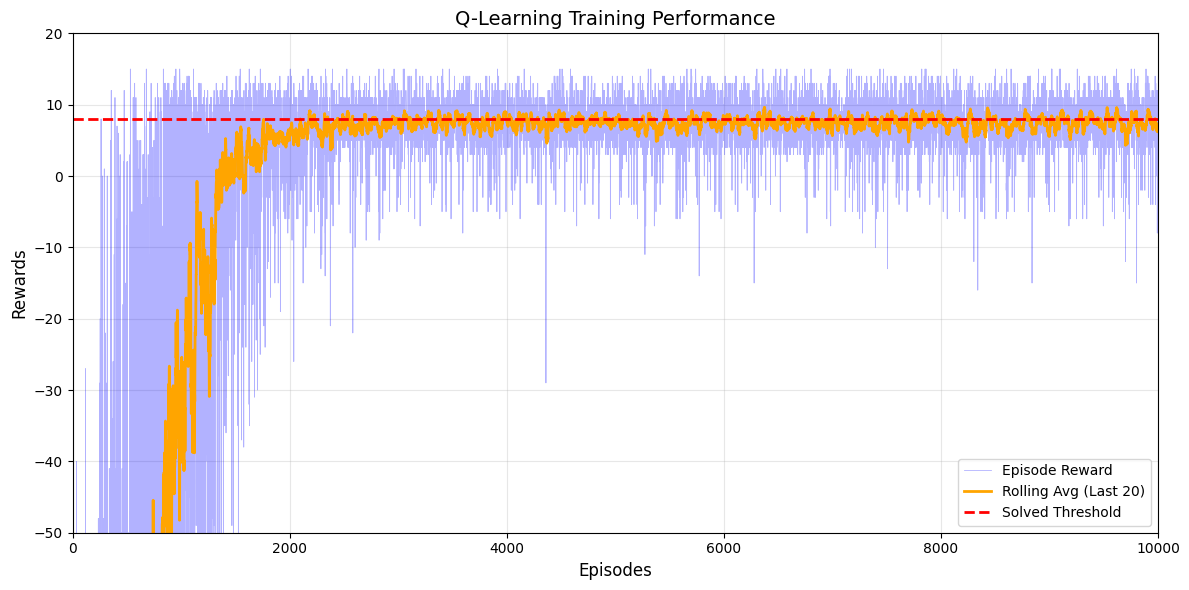

Config: {'alpha': 0.1, 'gamma': 0.99, 'decay_rate': 0.001, 'epsilon': 1.0, 'epsilon_min': 0.01}
Avg Reward (1000): 7.481


In [122]:
test_config = {
    "alpha": 0.1,
    "gamma": 0.99,
    "decay_rate": 0.001,
    "epsilon": 1.0,
    "epsilon_min": 0.01
}

result = train_q_learning(test_config)
print(f"Config: {result['config']}")
print(f"Avg Reward (1000): {result['avg_reward']}")

### Evaluation

In [123]:
evaluate_policy(result['Q'], result['env']) 

Evaluation Results over 100 episodes:
Avg Total Reward: 7.95
Avg Steps to Finish: 13.05
Success Rate: 100.00%


In [ ]:
# Visual
env = gym.make('Taxi-v3', render_mode = 'human')

Q = result['Q']
max_steps = 100
n_test_episodes = 10
test_rewards = []
env.reset()
env.render()

for _ in range(n_test_episodes):
    state = env.reset()[0]
    episode_reward = 0
    
    for _ in range(max_steps):
        action = np.argmax(Q[state])
        next_state, reward, done, _, _ = env.step(action)
        env.render()
        episode_reward += reward
        if done:
            break
        state = next_state
    
    test_rewards.append(episode_reward)

print(f"Average reward over {n_test_episodes} test episodes: {np.mean(test_rewards):.2f}")

Average reward over 10 test episodes: 6.50


In [125]:
print('Learned Q-Table:')
print(result['Q'])

Learned Q-Table:
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.63824917 -1.70356812 -2.3743438  -1.6355976   9.6220697  -4.91805529]
 [-0.88556253  0.61506309 -2.28499601 -2.35593741 14.11880599 -1.43949388]
 ...
 [-1.08470521 -1.07245296 -1.09451647 -1.07570907 -1.999      -1.95827551]
 [-2.54938609 -2.380405   -2.47022874 -2.48056983 -2.71       -2.8981    ]
 [-0.1999     -0.1999     -0.19        9.81184466 -1.         -1.        ]]


In [126]:
print('Policy Visualization (Before Pickup)')
visualize_policy_grid(result['Q'], result['env'], 0, 2)

print()

print('Policy Visualization (After Pickup)')
visualize_policy_grid(result['Q'], result['env'], 4, 2)

Policy Visualization (Before Pickup)
Taxi policy when passenger is at location Red (R) and destination is Yellow (Y)
p ← ↓ ↓ ← 
↑ ← ↓ ↓ ← 
↑ ↑ ← ← ← 
↑ ↑ ↑ ↑ ← 
↑ ↑ ↑ ↑ ← 

Policy Visualization (After Pickup)
Taxi policy when passenger is at location In Taxi and destination is Yellow (Y)
↓ ← ↓ ↓ ← 
↓ ← ↓ ← ← 
↓ ← ← ← ← 
↓ ↑ ↑ ↑ ← 
d ↓ ↑ ↑ ↑ 


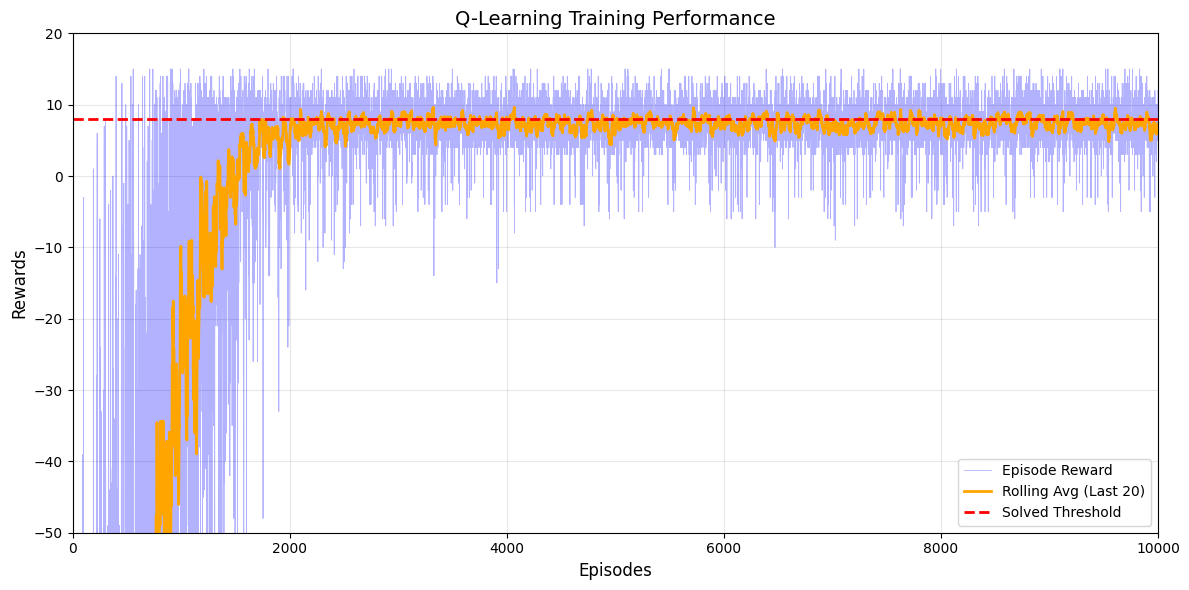

Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.0005}
Avg Reward: 7.323 | ε: 0.01


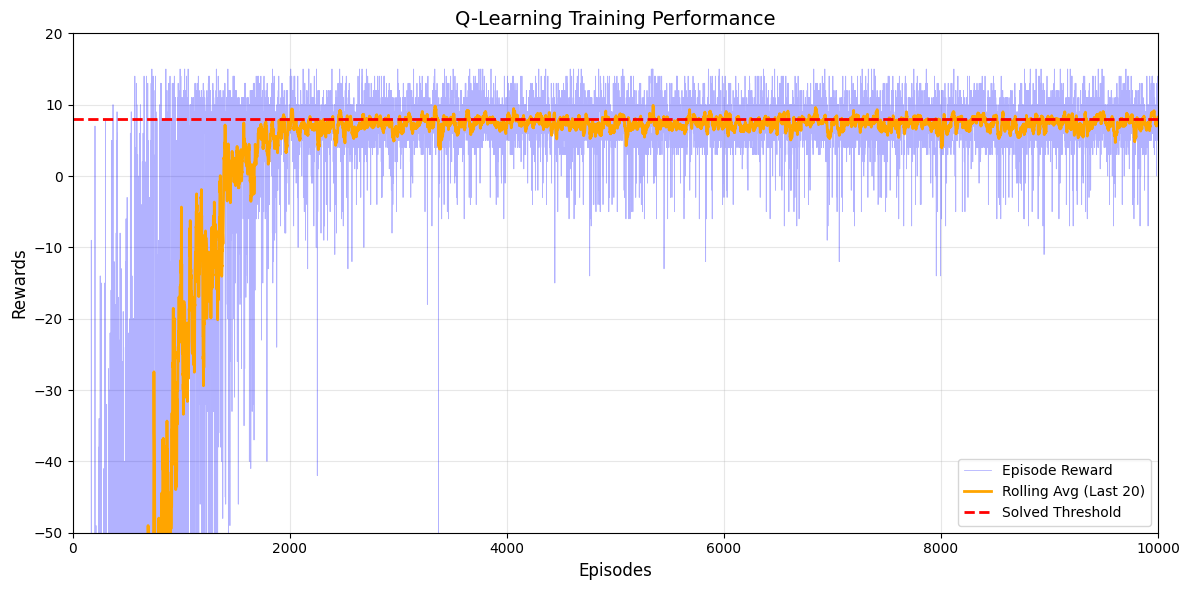

Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.001}
Avg Reward: 7.417 | ε: 0.01


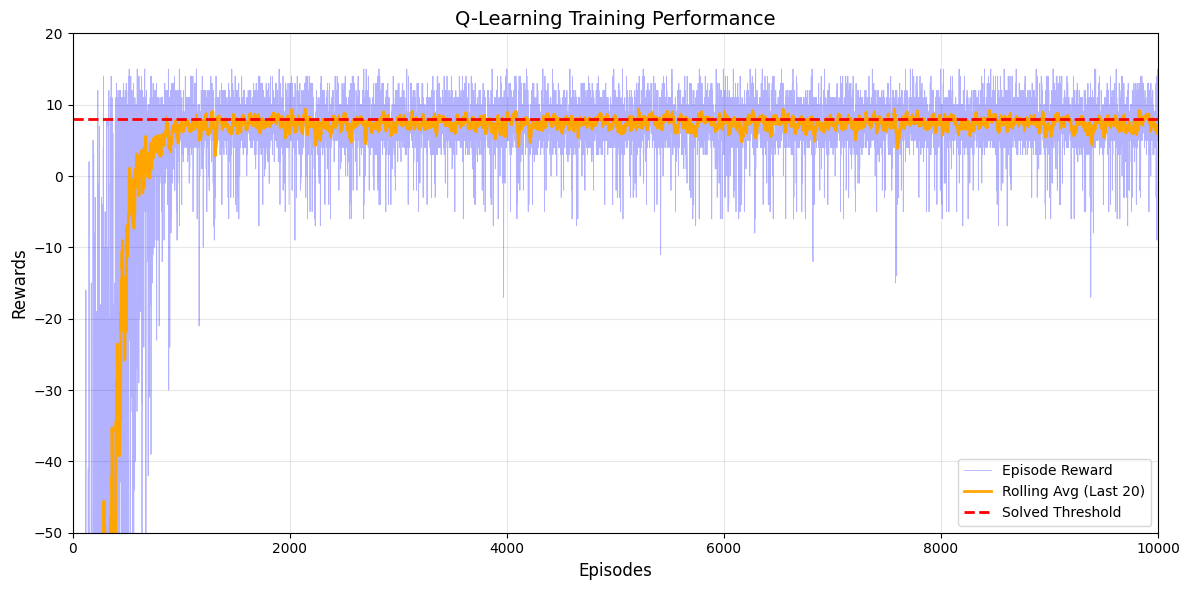

Config: {'gamma': 0.99, 'alpha': 0.3, 'decay_rate': 0.0005}
Avg Reward: 7.278 | ε: 0.01


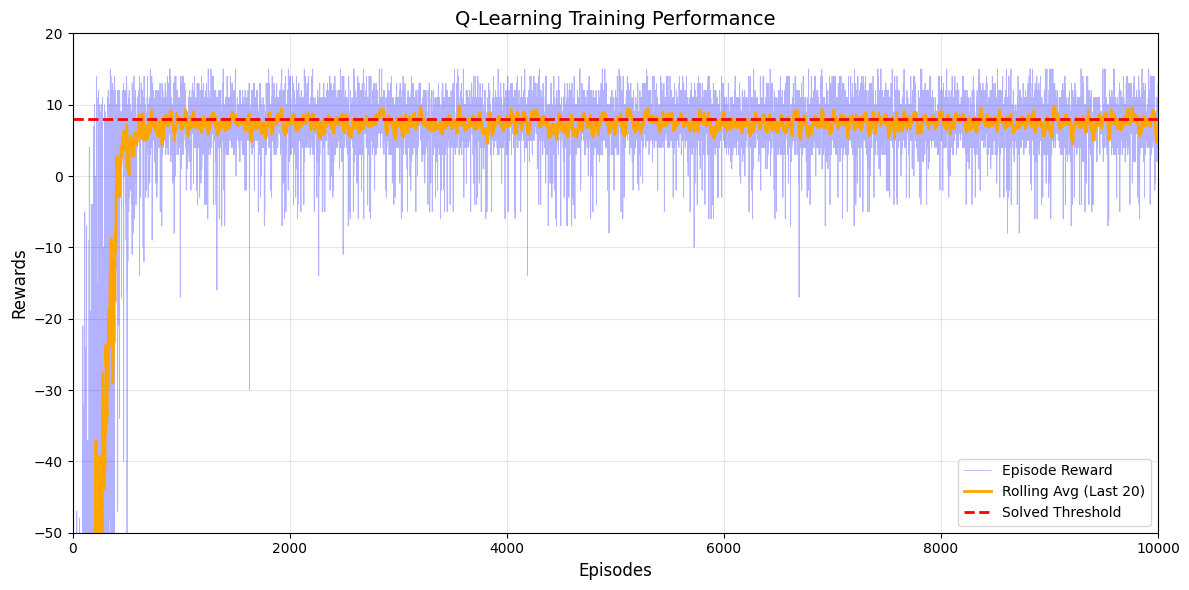

Config: {'gamma': 0.99, 'alpha': 0.5, 'decay_rate': 0.001}
Avg Reward: 7.488 | ε: 0.01


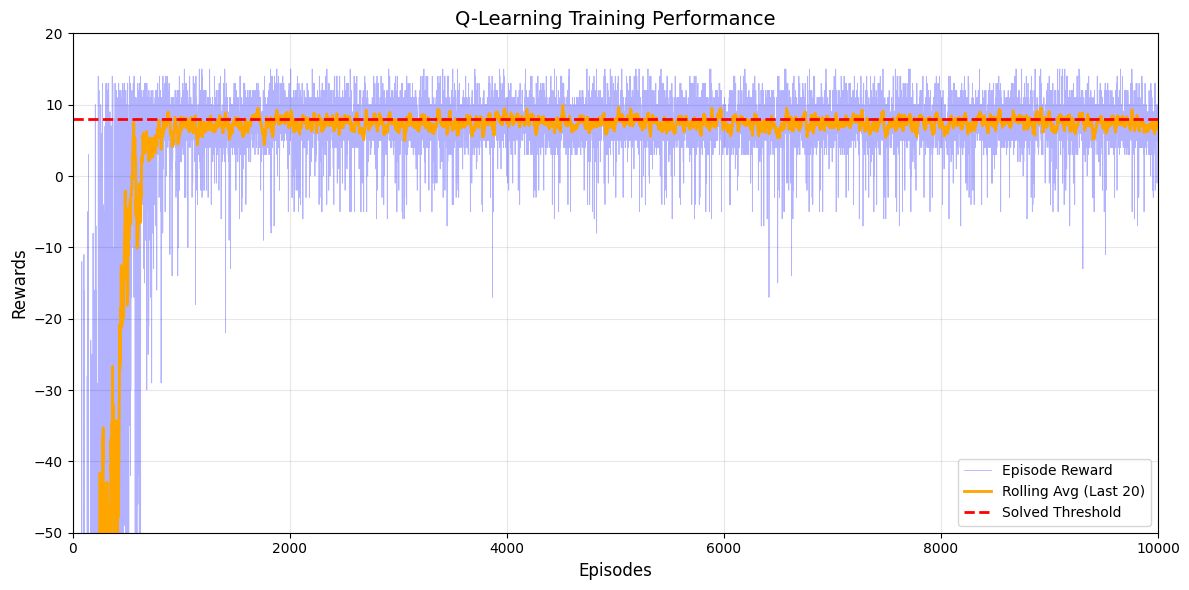

Config: {'gamma': 1.0, 'alpha': 0.3, 'decay_rate': 0.001}
Avg Reward: 7.301 | ε: 0.01


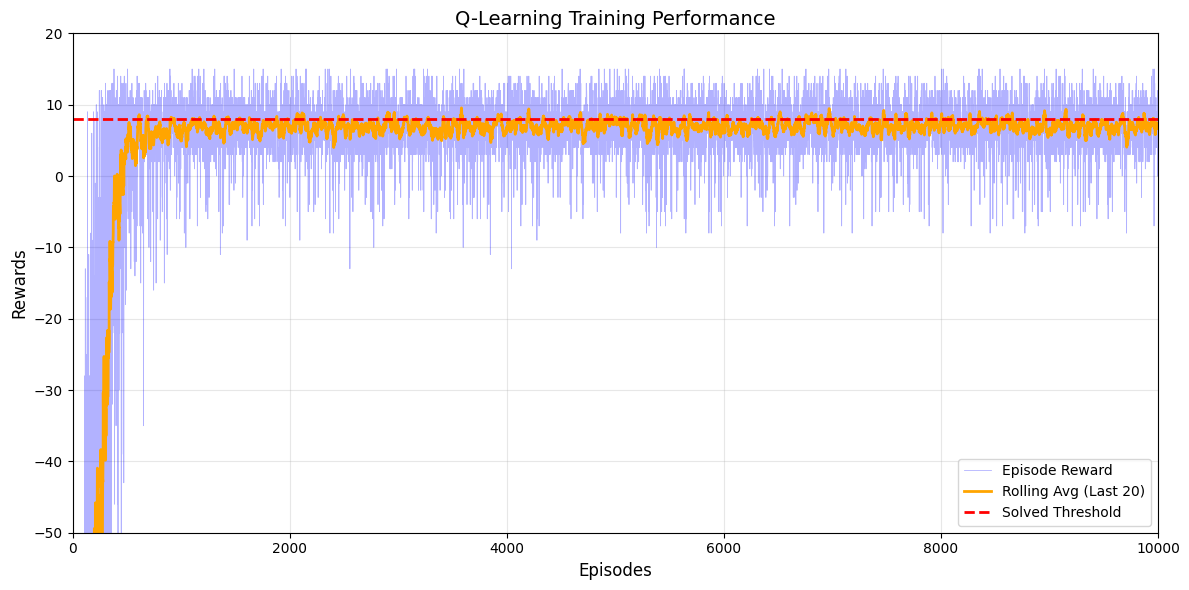

Config: {'gamma': 1.0, 'alpha': 0.5, 'decay_rate': 0.0005}
Avg Reward: 6.892 | ε: 0.01


In [127]:
test_configs = [
    {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.0005},
    {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.001},
    {"gamma": 0.99, "alpha": 0.3, "decay_rate": 0.0005},
    {"gamma": 0.99, "alpha": 0.5, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.3, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.5, "decay_rate": 0.0005},
]

results_list = []

for cfg in test_configs:
    cfg_copy = cfg.copy()
    result = train_q_learning(cfg_copy)
    print(f"Config: {result['config']}")
    print(f"Avg Reward: {result['avg_reward']} | ε: {result['ε']}")
    results_list.append(result)

In [128]:
best_result = max(results_list, key = lambda x: x['avg_reward'])

print('Best Config:')
print(f"Gamma: {best_result['config']['gamma']}")
print(f"Alpha: {best_result['config']['alpha']}")
print(f"Decay Rate: {best_result['decay_rate']}")
print(f"Final ε: {best_result['ε']:.4f}")
print(f"Avg Reward: {best_result['avg_reward']:.2f}")

Best Config:
Gamma: 0.99
Alpha: 0.5
Decay Rate: 0.001
Final ε: 0.0100
Avg Reward: 7.49


## Activity 4: **Q-Learning Approach for the Cartpole ENV**

In [147]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))

def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

print("Sample bins for interval (-5,5) with 10 bins'n", create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

discretize_bins([0.1, 0.5, 0.20, 0.4])

Sample bins for interval (-5,5) with 10 bins'n [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


(np.int64(11), np.int64(13), np.int64(8), np.int64(7))

In [151]:
def train_q_learning_cartpole(config, n_episodes=10000, max_steps=200):
    env = gym.make("CartPole-v1")

    def create_bins(interval, num_bins):
        return np.linspace(interval[0], interval[1], num_bins + 1)

    intervals = [(-5, 5), (-2, 2), (-0.5, 0.5), (-2, 2)]

    nbins = [20, 20, 10, 10]

    bins = [create_bins(intervals[i], nbins[i]) for i in range(4)]

    def discretize_bins(x):
        return tuple(min(np.digitize(x[i], bins[i]), nbins[i]) for i in range(4))

    Q = np.zeros(tuple(n + 1 for n in nbins) + (env.action_space.n,))

    alpha = config["alpha"]                  # Learning rate
    gamma = config["gamma"]                  # Discount factor
    epsilon = config["epsilon"]              # Initial exploration rate
    epsilon_min = config["epsilon_min"]      # Minimum exploration
    epsilon_decay = config["epsilon_decay"]  # Multiplicative decay rate per episode

    rewards = []
    solved = False
    solved_at = None

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = discretize_bins(state)
        total_reward = 0

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        for _ in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_bins(next_state)

            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            Q[state][action] += alpha * (td_target - Q[state][action])

            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)

        # Early stopping if solved: average of last 100 episodes >= 195
        if episode >= 100:
            avg_last_100 = np.mean(rewards[-100:])
            if avg_last_100 >= 195 and not solved:
                print(f"Solved at episode {episode}")
                solved = True
                solved_at = episode
                break

    rolling_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')

    plt.figure(figsize=(10, 6))
    plt.plot(rewards, alpha=0.3, label="Reward per Episode", color='skyblue')
    plt.plot(range(99, len(rewards)), rolling_avg, label="Rolling Avg (100)", color='orange', linewidth=2)
    plt.axhline(195, color='red', linestyle='--', label="Solved Threshold")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Q-Learning on CartPole-v1")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        "Q": Q,
        "rewards": rewards,
        "solved": solved,
        "solved_at": solved_at,
        "config": config
    }

def evaluate_q_policy_cartpole(Q, nbins, bins, episodes=10, delay=0.02):
    env = gym.make("CartPole-v1", render_mode="human")

    def discretize_state(state):
        return tuple(min(np.digitize(state[i], bins[i]), nbins[i]) for i in range(4))

    for ep in range(episodes):
        state, _ = env.reset()
        state = discretize_state(state)
        total_reward = 0
        done = False
        steps = 0

        while not done:
            action = np.argmax(Q[state])  # greedy policy
            state_, reward, done, _, _ = env.step(action)
            state = discretize_state(state_)
            total_reward += reward
            steps += 1
            time.sleep(delay)  # Optional: slow down for viewing

            if total_reward >= 1000:
                break            
        print(f"Episode {ep + 1}: Reward = {total_reward}, Steps = {steps}")

    env.close()

### Train Cartpole

Solved at episode 5504


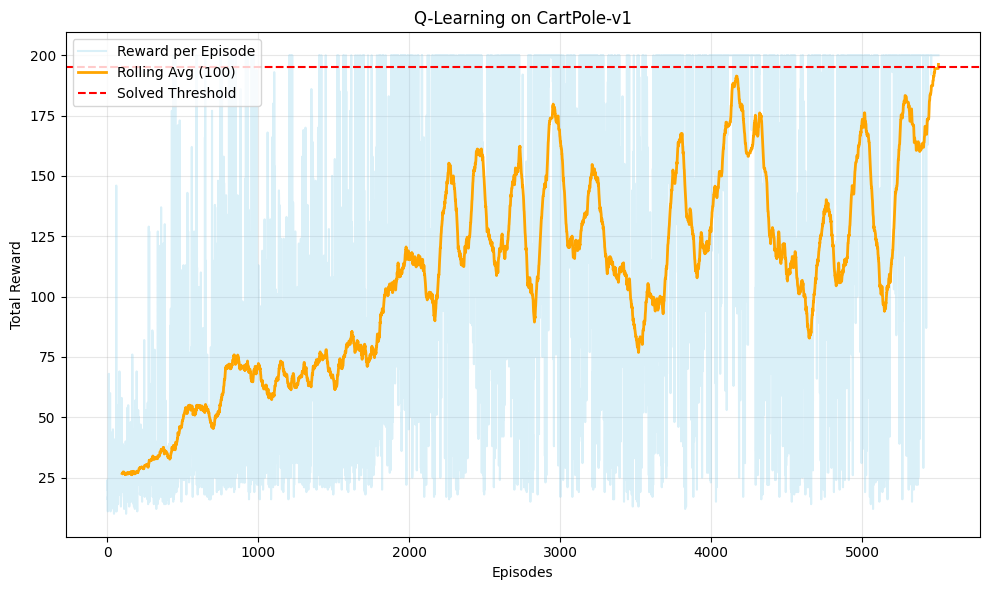

In [152]:
config = {
    "alpha": 0.1,
    "gamma": 0.99,
    "epsilon": 1.0,
    "epsilon_min": 0.05,
    "epsilon_decay": 0.995
}

results = train_q_learning_cartpole(config)

### Evaluate Cartpole

In [153]:
nbins = [20, 20, 10, 10]
intervals = [(-5, 5), (-2, 2), (-0.5, 0.5), (-2, 2)]
bins = [np.linspace(intervals[i][0], intervals[i][1], nbins[i] + 1) for i in range(4)]

evaluate_q_policy_cartpole(results["Q"], nbins, bins, episodes=10)

Episode 1: Reward = 1000.0, Steps = 1000
Episode 2: Reward = 1000.0, Steps = 1000
Episode 3: Reward = 1000.0, Steps = 1000
Episode 4: Reward = 1000.0, Steps = 1000
Episode 5: Reward = 1000.0, Steps = 1000
Episode 6: Reward = 1000.0, Steps = 1000
Episode 7: Reward = 1000.0, Steps = 1000
Episode 8: Reward = 1000.0, Steps = 1000
Episode 9: Reward = 1000.0, Steps = 1000
Episode 10: Reward = 1000.0, Steps = 1000


# Algorithm **Comparison** & **Bonus**

In [156]:
import imageio

def simulate_episode(env, Q, max_steps=100):
    frames = []
    state, _ = env.reset()
    frames.append(env.render())

    for _ in range(max_steps):
        action = np.argmax(Q[state])
        state, _, done, _, _ = env.step(action)
        frames.append(env.render())
        if done:
            break
    return frames

def train_mc_control_full_gif(env, config, gif_filename="mc_full_learning.gif", max_episodes_to_record=300):
    import imageio
    frames = []

    n_episodes = config["n_episodes"]
    max_steps = config["max_steps"]
    gamma = config["gamma"]
    alpha = config["alpha"]
    epsilon = config["epsilon"]
    epsilon_min = config["epsilon_min"]
    epsilon_decay = config["epsilon_decay"]

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))

    rewards = []
    converged_at = None

    for episode in range(n_episodes):
        state, _ = env.reset()
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        episode_states, episode_actions, episode_rewards = [], [], []

        for _ in range(max_steps):
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)

            if episode < max_episodes_to_record:
                frames.append(env.render())

            state = next_state
            if done:
                break

        G = 0
        visited = set()
        for t in reversed(range(len(episode_states))):
            s, a = episode_states[t], episode_actions[t]
            G = gamma * G + episode_rewards[t]
            if (s, a) not in visited:
                visited.add((s, a))
                N[s, a] += 1
                Q[s, a] += alpha * (G - Q[s, a])

        rewards.append(sum(episode_rewards))

        if episode >= 100:
            avg = np.mean(rewards[-100:])
            if avg >= 0.78 and converged_at is None:
                converged_at = episode

    imageio.mimsave(gif_filename, frames, duration=0.05)
    print(f"Saved full MC learning GIF to: {gif_filename}")
    return Q, rewards, converged_at

def train_sarsa_full_gif(env, config, gif_filename="sarsa_full_learning.gif", max_episodes_to_record=300):
    import imageio
    frames = []

    n_episodes = config["n_episodes"]
    max_steps = config["max_steps"]
    gamma = config["gamma"]
    alpha = config["alpha"]
    epsilon = config["epsilon"]
    epsilon_min = config["epsilon_min"]
    epsilon_decay = config["epsilon_decay"]

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    converged_at = None

    for episode in range(n_episodes):
        state, _ = env.reset()
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
        total_reward = 0

        for _ in range(max_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[next_state])

            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            state, action = next_state, next_action
            total_reward += reward

            if episode < max_episodes_to_record:
                frames.append(env.render())

            if done:
                break

        rewards.append(total_reward)

        if episode >= 100:
            avg_last_100 = np.mean(rewards[-100:])
            if avg_last_100 >= 0.78 and converged_at is None:
                converged_at = episode

    imageio.mimsave(gif_filename, frames, duration=0.05)
    print(f"Saved full SARSA learning GIF to: {gif_filename}")
    return Q, rewards, converged_at

def train_q_learning_full_gif(env, config, gif_filename="q_learning_full.gif", max_episodes_to_record=300):
    import imageio
    frames = []

    n_episodes = config["n_episodes"]
    max_steps = config["max_steps"]
    gamma = config["gamma"]
    alpha = config["alpha"]
    epsilon = config["epsilon"]
    epsilon_min = config["epsilon_min"]
    epsilon_decay = config["epsilon_decay"]

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    converged_at = None

    for episode in range(n_episodes):
        state, _ = env.reset()
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        total_reward = 0

        for _ in range(max_steps):
            action = env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state])
            next_state, reward, done, _, _ = env.step(action)

            best_next_action = np.argmax(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])

            state = next_state
            total_reward += reward

            if episode < max_episodes_to_record:
                frames.append(env.render())

            if done:
                break

        rewards.append(total_reward)

        if episode >= 100:
            avg = np.mean(rewards[-100:])
            if avg >= 0.78 and converged_at is None:
                converged_at = episode

    imageio.mimsave(gif_filename, frames, duration=0.05)
    print(f"Saved full learning process GIF: {gif_filename}")
    return Q, rewards, converged_at

def evaluate_policy(Q, env, n_episodes=100, max_steps=200, render=False, success_reward=None):
    total_rewards = []
    total_steps = []
    successful_episodes = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done and steps < max_steps:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1

            if render:
                env.render()

        if success_reward is not None and reward == success_reward:
            successful_episodes += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    success_rate = (successful_episodes / n_episodes) if success_reward is not None else None

    print(f"Evaluation Results over {n_episodes} episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Steps to Finish: {avg_steps:.2f}")
    if success_reward is not None:
        print(f"Success Rate: {success_rate * 100:.2f}%")

    return {
        "avg_reward": avg_reward,
        "avg_steps": avg_steps,
        "success_rate": success_rate
    }

In [157]:
# Configs
config_mc = {
    "n_episodes": 10000,
    "max_steps": 100,
    "gamma": 0.99,
    "alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_min": 0.01,
    "epsilon_decay": 0.995
}

config = {
    "n_episodes": 20000,
    "max_steps": 200,
    "gamma": 0.99,
    "alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_min": 0.01,
    "epsilon_decay": 0.995
}

# Results
results_summary = []

env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

# Monte Carlo (full learning gif)
start_mc = time.time()
Q_mc, rewards_mc, converged_mc = train_mc_control_full_gif(
    env, config_mc, gif_filename="videos/mc_full_learning.gif", max_episodes_to_record=300
)
time_mc = time.time() - start_mc
eval_mc = evaluate_policy(Q_mc, env, success_reward=1.0)
results_summary.append({
    "Algorithm": "Monte Carlo",
    "Avg Reward": eval_mc["avg_reward"],
    "Avg Steps": eval_mc["avg_steps"],
    "Success Rate": eval_mc["success_rate"],
    "Converged At": converged_mc,
    "Time (s)": round(time_mc, 2)
})

# SARSA (full learning gif)
start_sarsa = time.time()
Q_sarsa, rewards_sarsa, converged_sarsa = train_sarsa_full_gif(
    env, config, gif_filename="videos/sarsa_full_learning.gif", max_episodes_to_record=300
)
time_sarsa = time.time() - start_sarsa
eval_sarsa = evaluate_policy(Q_sarsa, env, success_reward=1.0)
results_summary.append({
    "Algorithm": "SARSA",
    "Avg Reward": eval_sarsa["avg_reward"],
    "Avg Steps": eval_sarsa["avg_steps"],
    "Success Rate": eval_sarsa["success_rate"],
    "Converged At": converged_sarsa,
    "Time (s)": round(time_sarsa, 2)
})

# Q-Learning (full learning gif)
start_ql = time.time()
Q_ql, rewards_ql, converged_ql = train_q_learning_full_gif(
    env, config, gif_filename="videos/q_learning_full_learning.gif", max_episodes_to_record=300
)
time_ql = time.time() - start_ql
eval_ql = evaluate_policy(Q_ql, env, success_reward=1.0)
results_summary.append({
    "Algorithm": "Q-Learning",
    "Avg Reward": eval_ql["avg_reward"],
    "Avg Steps": eval_ql["avg_steps"],
    "Success Rate": eval_ql["success_rate"],
    "Converged At": converged_ql,
    "Time (s)": round(time_ql, 2)
})

# Show results
results_df = pd.DataFrame(results_summary)
print("\n=== Comparison of RL Algorithms on FrozenLake ===")
print(results_df)

Saved full MC learning GIF to: videos/mc_full_learning.gif
Evaluation Results over 100 episodes:
Avg Total Reward: 1.00
Avg Steps to Finish: 6.00
Success Rate: 100.00%
Saved full SARSA learning GIF to: videos/sarsa_full_learning.gif
Evaluation Results over 100 episodes:
Avg Total Reward: 1.00
Avg Steps to Finish: 6.00
Success Rate: 100.00%
Saved full learning process GIF: videos/q_learning_full_learning.gif
Evaluation Results over 100 episodes:
Avg Total Reward: 1.00
Avg Steps to Finish: 6.00
Success Rate: 100.00%

=== Comparison of RL Algorithms on FrozenLake ===
     Algorithm  Avg Reward  Avg Steps  Success Rate  Converged At  Time (s)
0  Monte Carlo         1.0        6.0           1.0           362     17.22
1        SARSA         1.0        6.0           1.0           390     15.90
2   Q-Learning         1.0        6.0           1.0           369     14.64
